In [20]:
#import dependencies
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#get stored u/p
from login import username, pwd

In [2]:
select = 'SELECT * FROM '

deptSel = f'{select}departments'
deptCols = ['dept_no','dept_name']

deptEmpSel = f'{select}dept_emp'
deptEmpCols = ['emp_no','dept_no']

deptManSel = f'{select}dept_manager'
deptManCols = ['dept_no', 'emp_no']

empSel = f'{select}employees'
empCols = ['emp_no','emp_title_id','birth_date','first_name','last_name','sex','hire_date']

salSel = f'{select}salaries'
salCols = ['emp_no','salary']

titlesSel = f'{select}titles'
titlesCols = ['title_id','title']

In [3]:
param = {
    'host'      : 'localhost',
    'database'  : 'bootcamp',
    'user'      : username,
    'password'  : pwd
}

def connect(params_dic):
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print('Connection successful')
    return conn

In [4]:
def getDataframe(conn, select_query, column_names):
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print('Error: %s' % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

In [5]:
conn = connect(param)

# Execute the Dept query
deptDf = getDataframe(conn, deptSel, deptCols)
deptDf.head()

Connecting to the PostgreSQL database...
Connection successful


,dept_no,dept_name
0,d001,Marketing
1,d002,Finance
2,d003,Human Resources
3,d004,Production
4,d005,Development


In [6]:
# Execute the Dept emp query
deptEmpDf = getDataframe(conn, deptEmpSel, deptEmpCols)
deptEmpDf.head()

,emp_no,dept_no
0,10001,d005
1,10002,d007
2,10003,d004
3,10004,d004
4,10005,d003


In [7]:
# Execute the Titles query
titlesDf = getDataframe(conn, titlesSel, titlesCols)
titlesDf.head()

,title_id,title
0,s0001,Staff
1,s0002,Senior Staff
2,e0001,Assistant Engineer
3,e0002,Engineer
4,e0003,Senior Engineer


In [8]:
# Execute the Department Manager query
deptManDf = getDataframe(conn, deptManSel, deptManCols)
deptManDf.head()

,dept_no,emp_no
0,d001,110022
1,d001,110039
2,d002,110085
3,d002,110114
4,d003,110183


In [9]:
# Execute the Employee query
empDf = getDataframe(conn, empSel, empCols)
empDf.head()

,emp_no,emp_title_id,birth_date,first_name,last_name,sex,hire_date
0,473302,s0001,1953-07-25,Hideyuki,Zallocco,M,1990-04-28
1,475053,e0002,1954-11-18,Byong,Delgrande,F,1991-09-07
2,57444,e0002,1958-01-30,Berry,Babb,F,1992-03-21
3,421786,s0001,1957-09-28,Xiong,Verhoeff,M,1987-11-26
4,282238,e0003,1952-10-28,Abdelkader,Baumann,F,1991-01-18


In [10]:
# Execute the Salary query
salDf = getDataframe(conn, salSel, salCols)
salDf.head(100)

,emp_no,salary
0,10001,60117
1,10002,65828
2,10003,40006
3,10004,40054
4,10005,78228
...,...,...
95,10096,61395
96,10097,44886
97,10098,40000
98,10099,68781


In [11]:
commonSals = salDf.groupby('salary').agg(**{'Salary Counts':('salary','count')})
commonSals.sort_values('Salary Counts',ascending=False)

,Salary Counts
salary,
40000,95346
55581,19
53078,18
53738,18
45184,17
...,...
82417,1
82419,1
82423,1


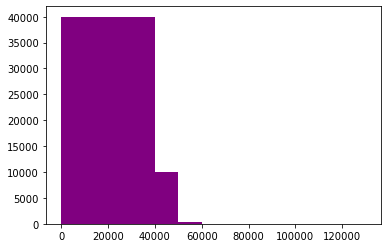

In [55]:
commonSals = salDf.groupby('salary')#.agg(**{'Salary Counts':('salary','count')})
countSals = commonSals['salary'].count()
countSals

bins = [0,39999, 49999, 59999, 69999, 79999, 89999, 130000]
groupNames = ['below 40k', '40k-49k','50k-59k','60k-69k','70k,79k','80k-89k','>90k']

xAxis=np.arange(len(commonSals))
tickLocs=[value for value in groupNames]
tickLocs

plt.hist(xAxis, bins=bins, color="purple", ) 
#          countSals, tick_label=countSals.index.values)
plt.show()

# groupDrugPly = cleanedDF.groupby('Drug Regimen')
# countDrugPly = groupDrugPly['Drug Regimen'].count()

# xAxis=np.arange(len(groupDrugPly))
# tickLocs=[value for value in xAxis]
# tickLocs

# plt.bar(xAxis, countDrugPly, color="orange", tick_label=countDrugPly.index.values)
# plt.xlabel('Drug Regimen')
# plt.ylabel("Number of Measurements")
# plt.xticks(rotation=45)
# plt.show()

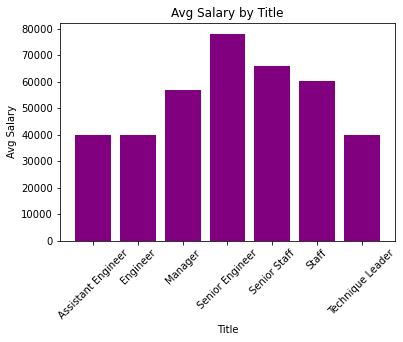

In [48]:
SalTitleDf = empDf.join(salDf,lsuffix='_emp',rsuffix='_sal') \
                    .join(titlesDf,lsuffix='_emp',rsuffix='_title')

grpSalTitleDf = SalTitleDf.groupby('title')
avgSalTitleDf = grpSalTitleDf['salary'].mean()
#avgSalTitleDf #sanity check

xAxis=np.arange(len(grpSalTitleDf))
tickLocs=[value for value in xAxis]
tickLocs

plt.bar(xAxis, avgSalTitleDf, color="purple", tick_label=avgSalTitleDf.index.values)
plt.title('Avg Salary by Title')
plt.xlabel('Title')
plt.ylabel("Avg Salary")
plt.xticks(rotation=45)
plt.show()

#### The highest avg salary for the given titles belongs to Senior Eng.